#### Load Libraries

In [6]:
# export
from fastai import *
from fastai.vision.all import *
import umap
import seaborn as sns
from torchvision import transforms
import numpy as np
from torch import nn
import torch
from modules_th.video_block import * 
from modules_th.triplet_loss import *
from modules_th.supcon_module import *
from modules_th.cus_cbs import *


In [7]:
from fastai.vision.all import *

## Mixed Model with Triplet Loss

In [2]:
bs = 32
path = untar_data(URLs.CALTECH_101)
files = get_image_files(path)
lbls = L(map(parent_label,files))
tfms = aug_transforms(size=224)

imgdata = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=UniformizedSplitter(files,lbls,uniformize_dataset),
                 get_y=parent_label,
                item_tfms= Resize(300,300),
                 batch_tfms= tfms +[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)])

In [5]:
embs_size = 128
n_el, n_lbl = 8,8


# Get data
df = pd.read_csv('experiments_on_images/train_CALTECH101.csv')
items = df.img_files.values
lbls = df.lbls.values

#Datasets and dataloaders
img_pip = [PILImage.create, Resize(512)]
lbl_pip = [parent_label, Categorize()]
pip = [img_pip, lbl_pip]
splits = ColSplitter('val')(df)
dsets = Datasets(items, pip, splits=splits)
tfms = aug_transforms(size=128)

dls = dsets.dataloaders(bs=n_el*n_lbl,
                        shuffle_train=True,
                        shuffle_fn=UniformizedShuffle(lbls[splits[0]], n_el=n_el,n_lbl=n_lbl), 
                        after_item=ToTensor(), 
                        after_batch = tfms +[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)] )

In [17]:
def my_splitter(model):
    return [params(model.encoder),params(model.head)]

In [16]:

learn.model[0]

TypeError: 'AnomalyDetectionModel' object is not subscriptable

In [18]:


head, body = create_head(4096, len(dls.vocab), lin_ftrs=[embs_size]), create_body(resnet50, cut=-2)
learn = Learner(dls, 
                AnomalyDetectionModel(body,head),
                SumLoss(TripletLoss,n_views=1,alpha=2.0, margin=.2),
                splitter=my_splitter,
                metrics=tl_accuracy)


In [19]:

sched = {'lr': combine_scheds([0.1,0.9], [SchedLin(0.0001,0.001), SchedCos(0.001, 0.0001)])}
custom_sched = ParamScheduler(sched)
Logs_csv =   CSVLogger(fname='logs_TLCE_bs16.csv', append=False) 
learn.add_cbs([LossesRecorderCallback(), Logs_csv])

learn.fine_tune(100, cbs= [Logs_csv])


epoch,train_loss,valid_loss,tl_accuracy,time


KeyboardInterrupt: 

In [7]:
learn.save('CEL_TL') # 8+1 epoche

Path('models/CEL_TL.pth')

In [4]:
# Umap Embs
cmap='tab10'
reducer = umap.UMAP()

ds_idx = 1 # working on validation

preds, lbls = learn.get_preds(ds_idx=ds_idx)

fv = preds[1]
UMAPembeddings=reducer.fit_transform(fv)

print(fv.shape)
print(lbls.shape)

NameError: name 'learn' is not defined

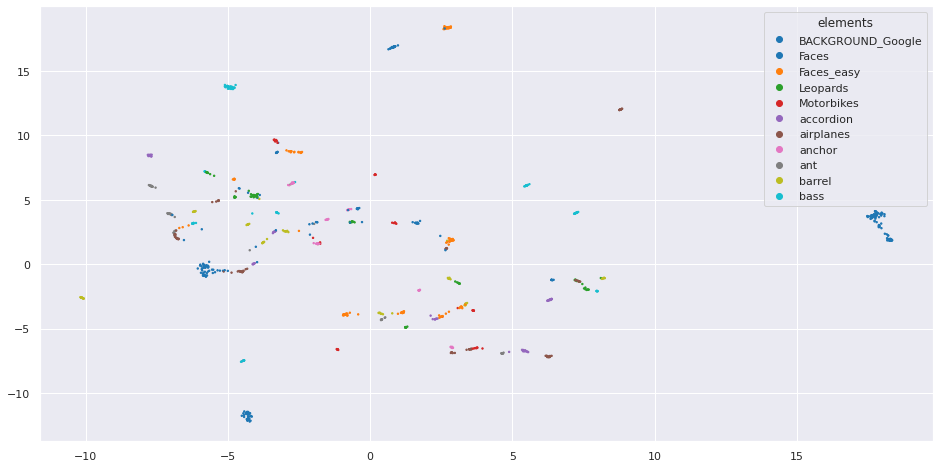

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))

scatter=ax.scatter(x=UMAPembeddings[:,0],y=UMAPembeddings[:,1], s=2, c=np.array(lbls),cmap=cmap)
#scatter=ax.scatter(x=fv[:,0],y=fv[:,1], s=2, c=np.array(lbls),cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0],labels=dls.vocab,
                    loc="upper right", title="elements")
plt.show()

In [3]:
from sklearn.metrics import silhouette_score
silhouette_score(fv,lbls)

NameError: name 'fv' is not defined

## Mixed Model with SupConLoss

In [9]:
#export
def read_data() : return pd.read_csv('/mnt/data/eugeniomarinelli/experiments_on_images/train_CALTECH101.csv')


In [8]:
 pd.read_csv('experiments_on_images/train_CALTECH101.csv')

,img_files,lbls,val
0,/home/eugenio/.fastai/data/caltech_101/Faces_easy/image_0435.jpg,Faces_easy,False
1,/home/eugenio/.fastai/data/caltech_101/airplanes/image_0524.jpg,airplanes,False
2,/home/eugenio/.fastai/data/caltech_101/trilobite/image_0060.jpg,trilobite,False
3,/home/eugenio/.fastai/data/caltech_101/trilobite/image_0049.jpg,trilobite,False
4,/home/eugenio/.fastai/data/caltech_101/airplanes/image_0086.jpg,airplanes,False
...,...,...,...
8225,/home/eugenio/.fastai/data/caltech_101/cougar_face/image_0069.jpg,cougar_face,False
8226,/home/eugenio/.fastai/data/caltech_101/cougar_body/image_0016.jpg,cougar_body,False
8227,/home/eugenio/.fastai/data/caltech_101/camera/image_0017.jpg,camera,False
8228,/home/eugenio/.fastai/data/caltech_101/watch/image_0225.jpg,watch,False


In [6]:
#export
def get_learner(items, loss='CEL-SCL', size=128, n_lbl=4 , n_el=4, embs_size=128,n_views=2):


    df = items
    items = df.img_files.values
    tr_lbls = df.lbls[1-df.val].values
    val_lbls = df.lbls[df.val].values

    img_pip = [PILImage.create, Resize(512)]
    lbl_pip = [parent_label, Categorize()]
    pip = [*[img_pip for _ in range(n_views)], lbl_pip]
    splits = ColSplitter('val')(df)
    dsets = Datasets(items, pip, splits=splits)
    tfms = aug_transforms(size=size)

    dls = dsets.dataloaders(bs=n_el*n_lbl,
                            after_item=ToTensor(),
                            after_batch = tfms +[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)] )

    #dls.train.shuffle_fn = UniformizedShuffle(tr_lbls,n_el=n_el,n_lbl=n_lbl)
    #dls.valid.shuffle_fn = UniformizedShuffle(val_lbls,n_el=n_el,n_lbl=n_lbl)

    dls.train.shuffle = True
    dls.valid.shuffle = True


    n_views = dls.n_inp
    encoder, head = create_body(resnet50,cut = -2),create_head(4096, len(dls.vocab), lin_ftrs=[embs_size])
    model = AnomalyDetectionModel(encoder, head)

    learn = Learner(dls, 
                    model, 
                    loss_func=SumLoss(SupConLoss,p='cos', alpha=1, n_views=n_views),
                   metrics=[supcon_accuracy, silh_score])
    learn.add_cbs([ContrastiveCallback(n_views)])
    return learn


In [12]:
df = read_data()
learn = get_learner(df)

In [ ]:

#sched = {'lr': combine_scheds([0.1,0.9], [SchedLin(0.0001,0.001), SchedCos(0.001, 0.0001)])}
Logs_csv =   CSVLogger(fname='logs_SCLCEL_bs16.csv', append=False) 
cbs= [Logs_csv]

learn.fine_tune(2)

In [59]:
learn.export('ML_16_epochs') #bs 16 epochs

AnomalyDetectionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [61]:
#torch.cuda.set_device(1)
learn = load_learner('ML_16_epochs.pkl',cpu=False ) # inserisci .pkl nel file

learn.validate(dl=dls.valid)

(#3) [1.030903935432434,0.8942891955375671,0.9260782587137141]

## Test

In [49]:
?? learn.get_preds

Signature:
 learn.get_preds(
    ds_idx=1,
    dl=None,
    with_input=False,
    with_decoded=False,
    with_loss=False,
    act=None,
    inner=False,
    reorder=True,
    cbs=None,
    save_preds=None,
    save_targs=None,
    concat_dim=0,
)
Docstring: Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`
Source:   
    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None,
                  inner=False, reorder=True, cbs=None, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
        else:
            try: len(dl)
            except TypeError as e:
                raise TypeError("`dl` is something other than a single `DataLoader` object")
        if reorder and hasattr(dl, 'get_idxs'):
            idxs = dl.get_idxs()
            dl = dl.new(get_idxs = _ConstantFunc(idxs))
        cb = Ga

In [62]:
# Test
df = pd.read_csv('experiments_on_images/train_CALTECH101.csv')
item = df.img_files.values[df.val.values]

test_dl = learn.dls.test_dl(item, with_labels=True) 
preds, lbls = learn.get_preds(dl=test_dl)

In [63]:
preds[0].shape

torch.Size([823, 102])

In [69]:
resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [64]:
# Umap Embs
cmap='tab10'
reducer = umap.UMAP()

fv = preds[1].unbind(dim=1)[0]

print(fv.shape)
print(lbls.shape)

UMAPembeddings=reducer.fit_transform(fv)

torch.Size([823, 128])
(823,)


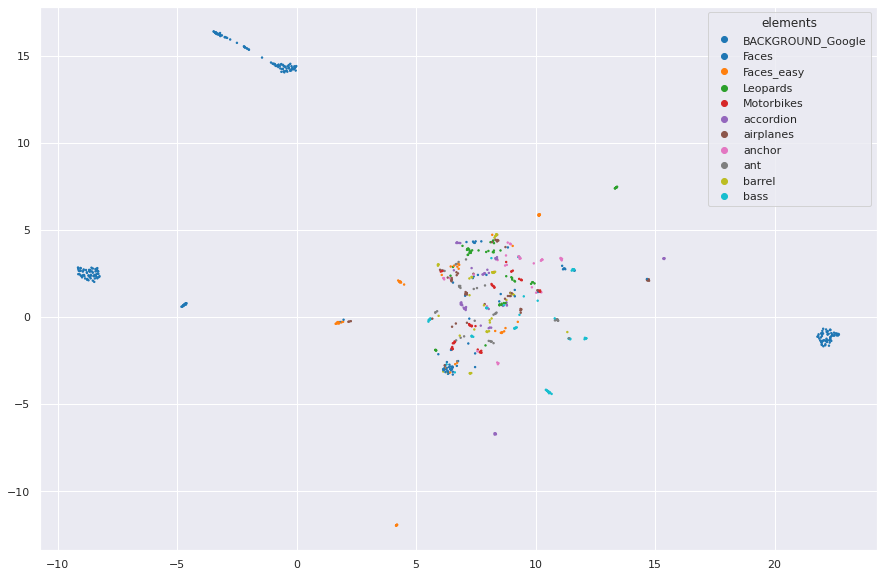

In [65]:
# Plot Umap Embs

fig, ax = plt.subplots(figsize=(15,10))
UMAPembeddings=reducer.fit_transform(fv)
scatter=ax.scatter(x=UMAPembeddings[:,0],y=UMAPembeddings[:,1], s=2, c=np.array(lbls),cmap=cmap)
#scatter=ax.scatter(x=fv[:,0],y=fv[:,1], s=2, c=np.array(lbls),cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0],labels=dls.vocab,
                    loc="upper right", title="elements")
plt.show()


In [66]:
# Mixed model 40 iteration, embs size 512

silh_score(fv,lbls)

0.42568272

In [67]:
accuracy(preds[0],lbls)

TensorCategory(0.0389)

In [155]:
preds[1].shape

torch.Size([914, 3, 128])

# Losses csv 

In [ ]:

def recorder_losses_avrg(record, epochs):
    tr=torch.stack(record).cpu().detach().numpy()
    bs_per_epochs = tr.shape[0]//epochs
    if tr.shape[0] != bs_per_epochs*epochs:
        print('Number of epochs could be wrong')
        excess = tr.shape[0]%epochs
        tr = tr[:-excess]
        
    return tr.reshape(epochs,bs_per_epochs).mean(axis=1)

cel_tr = recorder_losses_avrg(learn.losses_recorder.cel_losses[0],101)

cel_val = recorder_losses_avrg(learn.losses_recorder.cel_losses[1],101)

scl_tr = recorder_losses_avrg(learn.losses_recorder.usl_losses[0],101)
scl_val = recorder_losses_avrg(learn.losses_recorder.usl_losses[1],101)
scl_tr.shape
scl_val.shape[0]


In [130]:
DF = pd.DataFrame({'cel_train': cel_tr,
                   'cel_val': cel_val,
                  'scl_train':scl_tr,
                  'scl_val': scl_val})
DF.to_csv('experiments_on_images/losses_model_CELSCL_3mvw.csv',index_label='epoch')

In [5]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_triplet_loss.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 04_charades.ipynb.
Converted 05_ucf.ipynb.
Converted 06_distributed_inflated_NN.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_experiments_on_images.ipynb.
Converted 09_create_embeddings.ipynb.
Converted CustomCallbacks.ipynb.
Converted SupConModule.ipynb.
Converted Transformers.ipynb.
Converted UCF_SupCon.ipynb.
Converted distributed_training.ipynb.
Converted index.ipynb.
Converted mixedloss_images.ipynb.


In [ ]:
# default_exp train_imgs